# Wa-Tor, a predator-prey simulation

Diseñada por Alexander K. Dewdney en 1984
> Tiburones y peces libran una guerra ecológica en el planeta toroidal Wa-Tor (Scientific American)

## Panorama general

### 1. Sobre el planeta...
Se trata de un mundo toroidal representado por una cuadrícula bidimensional, cuyas celdas pueden estar vacías o contener una criatura (pez o tiburón).

### 2. La evolución a través del tiempo en pasos discretos (cronones)
Por cada cronon, las criaturas evolucionan de la siguiente manera:
* Inicialmente, se encuentran en una celda vacía
* Una criatura se mueve aleatoriamente a una celda adyacente en un vecindario vonNeumann

|   Escenario  |         Pez          |                Tiburón                   |
|    :----:    |       :----:         |                :----:                    |
| Todo ocupado |      Permanece       | Si es un pez, se lo come, sino permanece |
|  Todo vacío  | Movimiento aleatorio |         Movimiento aleatorio             |

* Después de que una criatura haya sobrevivido *fertility_threshold* cronones, deja un descendiente en la celda anterior después de moverse y su fertilidad se reinicia
* Cada cronon, se pierde una unidad de energía y, al llegar a 0, la criatura muere

## Imports

In [1]:
# El modelo puede contener múltiples agentes.
from mesa import Agent, Model # AGENTE: entidad que trabaja
                              # MODELO: espacio donde conviven los agentes (sistema)

from mesa.space import SingleGrid # Un agente por celda
from mesa.time import RandomActivation # Para que los agentes se activen de uno en uno aleatoriamente

# Se obtendrá información de cada paso de la simulación
from mesa.datacollection import DataCollector # DICCIONARIO: Colecta los datos

from random import randint # Para la toma de decisiones aleatorias

# Para crear una animación de cada uno de los pasos del modelo
#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Para personalizar la visualización de los datos
import seaborn as sns

# Paquetes para el mejor manejo de valores numéricos
import numpy as np  # Matrices...
#import pandas as pd # Manejo de datos (dataframes)

In [2]:
class Creature(Agent):
    def __init__(self, id, model, _type, energy):
        super().__init__(id, model)

        self._type = _type # 0:Fish | 1:Shark
        self.fertility_threshold = 0
        self.energy = energy

    def step(self):
        if self.energy == 0: # Muerte
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            return

        # von Newmann: arriba, abajo, derecha, izquierda
        movements = [(x,y) for (x,y) in self.model.grid.get_neighborhood(self.pos,
                                                  moore = False, 
                                                  include_center = False)]
        
        neighbors = [agent for agent in self.model.grid.get_neighbors(self.pos,
                                                  moore = False,
                                                  include_center = False)]
        
        fish = []

        for agent in neighbors:
            if agent._type == 0:
                fish.append(agent.pos)
            
            if agent.pos in movements:
                movements.remove(agent.pos)

        offspring = True if self.fertility_threshold >= self.model.fertility_threshold[self._type] else False
        prev = None
        
        if self._type == 1 and len(fish) > 0: # Tiburón con posibilidad de comer
            prev = self.pos
            _next = fish[ randint(0,len(fish)-1) ]
            remove = [prey for prey in neighbors if prey.pos == _next][0]

            self.model.grid.remove_agent(remove)
            self.model.schedule.remove(remove)
            self.energy += self.model.energy[1]

            self.model.grid.move_agent(self, _next)
            
        elif len(movements) > 0: # Se ocupa un espacio vacío
            prev = self.pos
            self.model.grid.move_agent(self, movements[ randint(0,len(movements)-1) ])

        if offspring and prev is not None:
            creature = Creature(self.model.agentId, self.model, self._type, self.model.energy[self._type])
            self.model.agentId += 1

            self.model.grid.place_agent(creature, prev)
            self.model.schedule.add(creature)
            self.fertility_threshold = -1 # Para que al final del step quede en 0

        self.energy -= 1
        self.fertility_threshold += 1

In [3]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))

    for (content,(x,y)) in model.grid.coord_iter():
        if content == None:
            grid[x][y] = 4 
        elif content._type == 1: # 1:Shark
            grid[x][y] = 5 
        else: # 0:Fish
            grid[x][y] = 1 

    return grid

In [4]:
class WaTorModel(Model):
    def __init__(self, width, height, total, fertility_threshold, energy): # [0:Fish, 1:Shark]
        self.grid = SingleGrid(width, height, torus=True) # Espacio bidimensional y toroidal que soporta un agente por celda
        self.schedule = RandomActivation(self) # De uno en uno
        self.datacollector = DataCollector(
            model_reporters = {"Grid": get_grid}
        )

        # Se almacena la información general de cada criatura
        self.fertility_threshold = fertility_threshold
        self.energy = energy
        self.agentId = 0

        for i in range(total[0]):
            agent = Creature(self.agentId, self, 0, self.energy[0])
            
            self.grid.move_to_empty(agent)
            self.schedule.add(agent)

            self.agentId += 1
        
        for i in range(total[1]):
            agent = Creature(self.agentId, self, 1, self.energy[1])

            self.grid.move_to_empty(agent)
            self.schedule.add(agent)

            self.agentId += 1
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [5]:
MAX_GENERATIONS = 400
WIDTH = 75 #75
HEIGHT = 50 #50

# [0:Fish, 1:Shark]
AGENTS = [160,40] #[120,40]
FERTILITY_THRESHOLD = [4,12] #[4,12]
ENERGY = [20,3] #[20,3]

model = WaTorModel(WIDTH, HEIGHT, AGENTS, FERTILITY_THRESHOLD, ENERGY)
for i in range(MAX_GENERATIONS):
    model.step()

In [6]:
all_grid = model.datacollector.get_model_vars_dataframe() # Arreglo de matrices

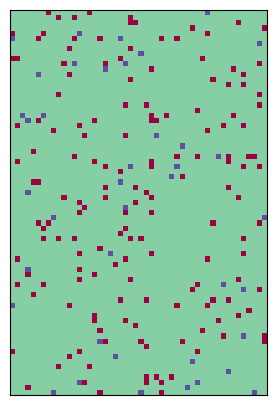

In [7]:
fig, axis = plt.subplots(figsize = (5, 5)) # 5x5 pulgadas
axis.set_xticks([])
axis.set_yticks([])

patch = plt.imshow(all_grid.iloc[0][0], cmap = sns.color_palette("Spectral", as_cmap=True))

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames = MAX_GENERATIONS)

In [8]:
anim